In [1]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
import torch as t
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
from src.caseDataset import CaseDataset

## Check GPU Availability

In [4]:
# Check GPU status:
print('PyTorch version:',t.__version__)
useGPU = t.cuda.is_available()
if(useGPU):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    dev = t.cuda.current_device()
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 1.8.2
Device  0 : NVIDIA GeForce GTX 1050
Current: Device  0


## Load Data

In [5]:
# load data
txtSubname = "contiPositiveAge"
oldData = pd.read_csv('./data/oldData{}.csv'.format(txtSubname)).iloc[:, 1:]
youngData = pd.read_csv('./data/youngData{}.csv'.format(txtSubname)).iloc[:, 1:]
totalData = pd.read_csv('./data/totalData{}.csv'.format(txtSubname)).iloc[:, 1:]
coef = np.loadtxt('./data/coef.txt')
A, B, C, D = coef[0], coef[1], coef[2], coef[3]
totalData

,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
0,1.0,0.28,-1.0,1.0,195.0,-65.0,199.966616,-72.963256,139.2,69.2,140.091105,66.638198,139.2,16.0,129.987863,19.166564
1,1.0,0.14,-1.0,1.0,195.0,-65.0,188.534435,-57.193869,119.6,49.6,121.403808,46.406782,119.6,23.0,127.079184,19.969171
2,-1.0,0.70,1.0,-1.0,-5.0,-125.0,-9.382402,-128.791270,-135.0,-65.0,-136.436100,-75.735351,-135.0,68.0,-140.986203,68.859754
3,1.0,0.04,-1.0,-1.0,-125.0,-5.0,-125.697061,-1.522448,-32.0,-102.0,-18.223095,-99.601897,-24.4,-102.0,-30.161104,-108.893942
4,1.0,0.18,-1.0,-1.0,-125.0,-5.0,-118.179846,-5.754429,-39.0,-109.0,-38.967583,-110.765390,-4.8,-109.0,2.005894,-106.929829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.0,0.98,1.0,-1.0,-5.0,-125.0,-7.057795,-130.890330,-149.0,-79.0,-145.511445,-72.952934,-149.0,107.2,-148.429670,103.788289
996,1.0,0.08,-1.0,-1.0,-125.0,-5.0,-123.763853,2.148185,-34.0,-104.0,-34.648330,-107.626314,-18.8,-104.0,-29.520529,-107.023702
997,1.0,0.08,-1.0,1.0,195.0,-65.0,190.409335,-71.021671,111.2,41.2,112.865682,39.057151,111.2,26.0,119.830089,23.074255
998,1.0,0.40,-1.0,1.0,195.0,-65.0,191.676938,-64.637119,156.0,86.0,155.196624,76.073283,156.0,10.0,157.932497,15.167533


In [6]:
totalData.describe()

,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
count,1000.0000,1000.000000,1000.0000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0000,51.000000,0.0000,0.0000,0.000000,0.000000,0.049290,-0.439106,22.950000,22.95000,22.969470,22.775650,-0.165400,46.065400,-0.278294,46.261861
std,1.0005,28.876181,1.0005,1.0005,120.372295,120.372295,120.468645,120.445122,119.422683,125.70211,119.576194,125.783367,98.734018,115.865692,98.936338,116.022074
min,-1.0000,2.000000,-1.0000,-1.0000,-125.000000,-125.000000,-141.474921,-139.908338,-150.000000,-150.00000,-157.402480,-150.166907,-150.000000,-150.000000,-157.460064,-140.421977
25%,-1.0000,26.000000,-1.0000,-1.0000,-80.000000,-80.000000,-92.477735,-90.234445,-86.500000,-85.25000,-81.738515,-89.339125,-46.900000,-35.150000,-55.077388,-35.228550
50%,0.0000,51.000000,0.0000,0.0000,-35.000000,-35.000000,-35.929213,-32.945000,3.700000,-1.60000,11.113954,-10.356589,-4.000000,29.000000,-4.087922,34.974341
75%,1.0000,76.000000,1.0000,1.0000,45.000000,45.000000,51.696634,53.348363,136.400000,126.60000,136.472045,123.598113,102.800000,110.000000,92.326840,120.207146
max,1.0000,100.000000,1.0000,1.0000,195.000000,195.000000,207.729016,206.330404,212.000000,240.00000,216.317747,249.683707,212.000000,240.000000,206.634638,251.629420


In [7]:
trainData, testData = totalData, totalData#train_test_split(totalData, test_size=0.2)

caseType = 2
trainCaseData = CaseDataset(trainData, caseType=caseType)
testCaseData = CaseDataset(testData, caseType=caseType)
print("TrainCase Treat Rate: {}".format(np.mean(trainCaseData.T == 1)))
print("TestCase Treat Rate: {}".format(np.mean(testCaseData.T == 1)))

TrainCase Treat Rate: 0.5
TestCase Treat Rate: 0.5


In [8]:
iteration = 1
trainDataLoader = DataLoader(trainCaseData, batch_size=int(len(trainCaseData)/iteration), shuffle=True)
print("Batched Training Shape of")
for i, (batchFeature, batchTarget) in enumerate(trainDataLoader):
    print("No. {} | Feature: {} | Target: {}".format(i, batchFeature.shape, batchTarget.shape))
print("\n")
testDataLoader = DataLoader(testCaseData, batch_size=int(len(testCaseData)/iteration), shuffle=False)
testFeature, testTarget = next(iter(testDataLoader))
print("Test Shape of \nFeature: {} | Target: {}".format(testFeature.shape, testTarget.shape))

Batched Training Shape of
No. 0 | Feature: torch.Size([1000, 3]) | Target: torch.Size([1000])


Test Shape of 
Feature: torch.Size([1000, 3]) | Target: torch.Size([1000])


---

## Model Build Up

In [9]:
from src.neuralNetwork import *
from os import path

In [10]:
doRetrain = True
PATH="./modelStorage/case{}Model{}.pth".format(caseType, txtSubname)
if path.isfile(PATH):
    model = NeuralNetwork()
    if not doRetrain:
        model.load_state_dict(t.load(PATH))
        print('load model from '+PATH)
        doTrainModel = False
    elif doRetrain:
        doTrainModel = True
else:
    print('create new model')
    model = NeuralNetwork()
    doTrainModel = True

In [11]:
loss_fn = t.nn.MSELoss()
learningRate = 1e-5
optimizer = t.optim.RMSprop(model.parameters())#, lr=learningRate)


model = model.to(dev)
loss_fn = loss_fn.to(dev)
if useGPU:
    print('---------- Turn Model/LossFunction into GPU ----------')
else:
    print('---------- Turn Model/LossFunction into CPU ----------')
print(model)

---------- Turn Model/LossFunction into GPU ----------
NeuralNetwork(
  (linearLayer): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [12]:
#del model

In [13]:
numEpochs = 1500

if doTrainModel:
    for epochIdx in range(numEpochs+1):
        loss = trainLoop(dataLoader=trainDataLoader, model=model, optimizer=optimizer, lossFn=loss_fn, dev=dev)
        if epochIdx % 250 == 0:
            print('-' * 20 + str(epochIdx) + '-' * 20)    
            print('Loss: {}'.format(loss))


print('=' * 10 + 'COMPLETE' + '=' * 10)

--------------------0--------------------
Loss: 14940.9423828125
--------------------250--------------------
Loss: 394.82989501953125
--------------------500--------------------
Loss: 149.69932556152344
--------------------750--------------------
Loss: 187.22628784179688
--------------------1000--------------------
Loss: 119.02056884765625
--------------------1250--------------------
Loss: 225.1045684814453
--------------------1500--------------------
Loss: 56.79176330566406
==========COMPLETE==========


In [14]:
yTrainPred = evaluate(model, trainCaseData.feature, dev=dev)
yTrainPredCF = evaluate(model, trainCaseData.featureCF, dev=dev)

In [15]:
doDraw = True

In [16]:
import matplotlib.pyplot as plt 
import numpy as np 
def drawOutcomesVersusRandom(trainCaseData, yPred, yType, coefficients, title, yPredCF=None):
    uniqueOutcome, countUnique = np.unique(trainCaseData.data['yo'+yType], return_counts=True)
    A, B, C, D = coefficients[0], coefficients[1], coefficients[2], coefficients[3]
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(len(uniqueOutcome)):
        # ========== Treated
        if np.sum([(trainCaseData.data['T'] == 1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])]):
            condition = (trainCaseData.data['T'] == 1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])
            VP = plt.violinplot(np.array(trainCaseData.data['y'+yType][condition]), \
                          positions=[uniqueOutcome[i]], widths=15)
            for pc in VP['bodies']:
                pc.set_facecolor('green')
                pc.set_edgecolor('green')
            for partname in ('cbars','cmins','cmaxes'):
                vp = VP[partname]
                vp.set_edgecolor('green')
                vp.set_facecolor('green')
                vp.set_linewidth(1)
            plt.text(x=uniqueOutcome[i], y=uniqueOutcome[i] + 1.1 * (np.max(trainCaseData.data['y'+yType][trainCaseData.data['yo'+yType] == uniqueOutcome[i]])-uniqueOutcome[i]), 
                     s=np.sum(condition), #np.array(countUnique, dtype=str)[i], \
                     color='green', fontsize=25, ha='center')

        # ========== Untreated
        elif np.sum([(trainCaseData.data['T'] == -1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])]):
            condition = (trainCaseData.data['T'] == -1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])
            VP = plt.violinplot(np.array(trainCaseData.data['y'+yType][condition]), \
                          positions=[uniqueOutcome[i]], widths=15)
            for pc in VP['bodies']:
                pc.set_facecolor('red')
                pc.set_edgecolor('red')
            for partname in ('cbars','cmins','cmaxes'):
                vp = VP[partname]
                vp.set_edgecolor('red')
                vp.set_facecolor('red')
                vp.set_linewidth(1)
            plt.text(x=uniqueOutcome[i], y=uniqueOutcome[i] + 1.1 * (np.max(trainCaseData.data['y'+yType][trainCaseData.data['yo'+yType] == uniqueOutcome[i]])-uniqueOutcome[i]), 
                     s=np.sum(condition), #np.array(countUnique, dtype=str)[i], \
                     color='red', fontsize=25, ha='center')

    size = 70
    plt.scatter(trainCaseData.data['yo'+yType], trainCaseData.data['yo'+yType], color='black', zorder=3)
    plt.scatter(trainCaseData.data['yo'+yType], trainCaseData.data['yo'+yType+'CF'], color='black', zorder=3, marker='x')
    if title == "Total":
        plt.scatter(trainCaseData.data['yo'+yType], yPred, color='blue', zorder=3, alpha=0.5, label='Total Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType], yPredCF, \
                        color='red', zorder=3, alpha=0.5, label='Total CF Prediction', s=size*0.5, marker='x')
        
    elif title == "Old":
        plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == 1], yPred[trainCaseData.Age == 1], color='blue', \
                    zorder=3, alpha=0.5, label='Old Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == 1], yPredCF[trainCaseData.Age == 1], \
                        color='red', zorder=3, alpha=0.5, label='Old CF Prediction', s=size*0.5, marker='x')

    elif title == "Young":
        plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == -1], yPred[trainCaseData.Age == -1], \
                    color='blue', zorder=3, alpha=0.5, label='Young Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == -1], yPredCF[trainCaseData.Age == -1], \
                        color='red', zorder=3, alpha=0.5, label='Young CF Prediction', s=size*0.5, marker='x')
            
    plt.xlabel('Without Noise', fontsize=30)
    plt.xticks(fontsize=30)
    plt.ylabel('With Noise', fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylim(np.min(uniqueOutcome)-(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.2, np.max(uniqueOutcome)+(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.5)
    plt.xlim(np.min(uniqueOutcome)-(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.2, np.max(uniqueOutcome)+(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.5)
    plt.legend(fontsize=20, loc='upper right')
    if title:
        plt.title("Prediction | Case {} | {}".format(yType, title), fontsize=30)
    plt.show()


In [17]:
def drawOutcomes(caseData, yType, titleAppend):
    yClass = 'y{}'.format(yType)
    yClassCF = 'y{}CF'.format(yType)
    data = caseData.data
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    # treat & male
    condition = np.logical_and(data['T']==1, data['Sex']==1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='blue')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='blue', marker='x')
    # treat & female
    condition = np.logical_and(data['T']==1, data['Sex']==-1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='red')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='red', marker='x')
    # untreat & male
    condition = np.logical_and(data['T']==-1, data['Sex']==1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='blue', marker='x')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='blue')
    # untreat & female
    condition = np.logical_and(data['T']==-1, data['Sex']==-1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='red', marker='x')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='red')
    
    xAmplitude = (np.max(data['Age']) - np.min(data['Age']))/2
    axs[0].set_xlim(np.min(data['Age'])-(xAmplitude)*0.1, np.max(data['Age'])+(xAmplitude)*0.1)
    axs[1].set_xlim(np.min(data['Age'])-(xAmplitude)*0.1, np.max(data['Age'])+(xAmplitude)*0.1)
    
    yAmplitude = (np.max(data[yClass]) - np.min(data[yClass]))/2
    axs[0].set_ylim(np.min(data[yClass])-(yAmplitude)*0.1, np.max(data[yClass])+(yAmplitude)*0.1)
    axs[1].set_ylim(np.min(data[yClass])-(yAmplitude)*0.1, np.max(data[yClass])+(yAmplitude)*0.1)
    
    axs[0].set_xlabel('Age', fontsize=20)
    axs[0].tick_params(axis='both', labelsize=20)
    axs[0].set_ylabel('Outcome', fontsize=20)
    axs[1].set_xlabel('Age', fontsize=20)
    axs[1].tick_params(axis='both', labelsize=20)
    axs[1].set_ylabel('Counterfactual Outcome', fontsize=20)
    fig.suptitle('Case {} | {}'.format(yType, titleAppend), fontsize=40)
    plt.show()

In [18]:
def drawTruthNoise(caseData, prediction, predictionCF, yType, titleAppend):
    yClass = 'y{}'.format(yType)
    yoClass = 'yo{}'.format(yType)
    yClassCF = 'y{}CF'.format(yType)
    yoClassCF = 'yo{}CF'.format(yType)

    data = caseData.data
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].plot([np.min(data[yClass]), np.max(data[yClass])], [np.min(data[yClass]), np.max(data[yClass])], color='grey')
    axs[1].plot([np.min(data[yClass]), np.max(data[yClass])], [np.min(data[yClass]), np.max(data[yClass])], color='grey')
    axs[0].scatter(data[yClass], data[yoClass], zorder=1, c='black')
    axs[1].scatter(data[yClassCF], data[yoClassCF], zorder=1, c='black')
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    # treat & male
    condition = np.logical_and(data['T']==np.max(data['T']), data['Sex']==np.max(data['Sex']))
    axs[0].scatter(data[yClass][condition], prediction[condition], color='blue')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='blue', marker='x')
    # treat & female
    condition = np.logical_and(data['T']==np.max(data['T']), data['Sex']==np.min(data['Sex']))
    axs[0].scatter(data[yClass][condition], prediction[condition], color='red')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='red', marker='x')
    # untreat & male
    condition = np.logical_and(data['T']==np.min(data['T']), data['Sex']==np.max(data['Sex']))
    axs[0].scatter(data[yClass][condition], prediction[condition], color='blue', marker='x')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='blue')
    # untreat & female
    condition = np.logical_and(data['T']==np.min(data['T']), data['Sex']==np.min(data['Sex']))
    axs[0].scatter(data[yClass][condition], prediction[condition], color='red', marker='x')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='red')
    
    xAmplitude = (np.max(data[yClass]) - np.min(data[yClass]))/2
    axs[0].set_xlim(np.min(data[yClass])-(xAmplitude)*0.1, np.max(data[yClass])+(xAmplitude)*0.1)
    axs[1].set_xlim(np.min(data[yClassCF])-(xAmplitude)*0.1, np.max(data[yClassCF])+(xAmplitude)*0.1)
    
    yAmplitude = (np.max(data[yClass]) - np.min(data[yClass]))/2
    axs[0].set_ylim(np.min(data[yClass])-(yAmplitude)*0.1, np.max(data[yClass])+(yAmplitude)*0.1)
    axs[1].set_ylim(np.min(data[yClassCF])-(yAmplitude)*0.1, np.max(data[yClassCF])+(yAmplitude)*0.1)
    
    axs[0].set_xlabel('Truth+Noise', fontsize=20)
    axs[0].tick_params(axis='both', labelsize=20)
    axs[0].set_ylabel('Factual Prediction', fontsize=20)
    axs[1].set_xlabel('Truth+Noise', fontsize=20)
    axs[1].tick_params(axis='both', labelsize=20)
    axs[1].set_ylabel('Counterfactual Prediction', fontsize=20)
    fig.suptitle('Case {}'.format(yType), fontsize=40)
    plt.show()

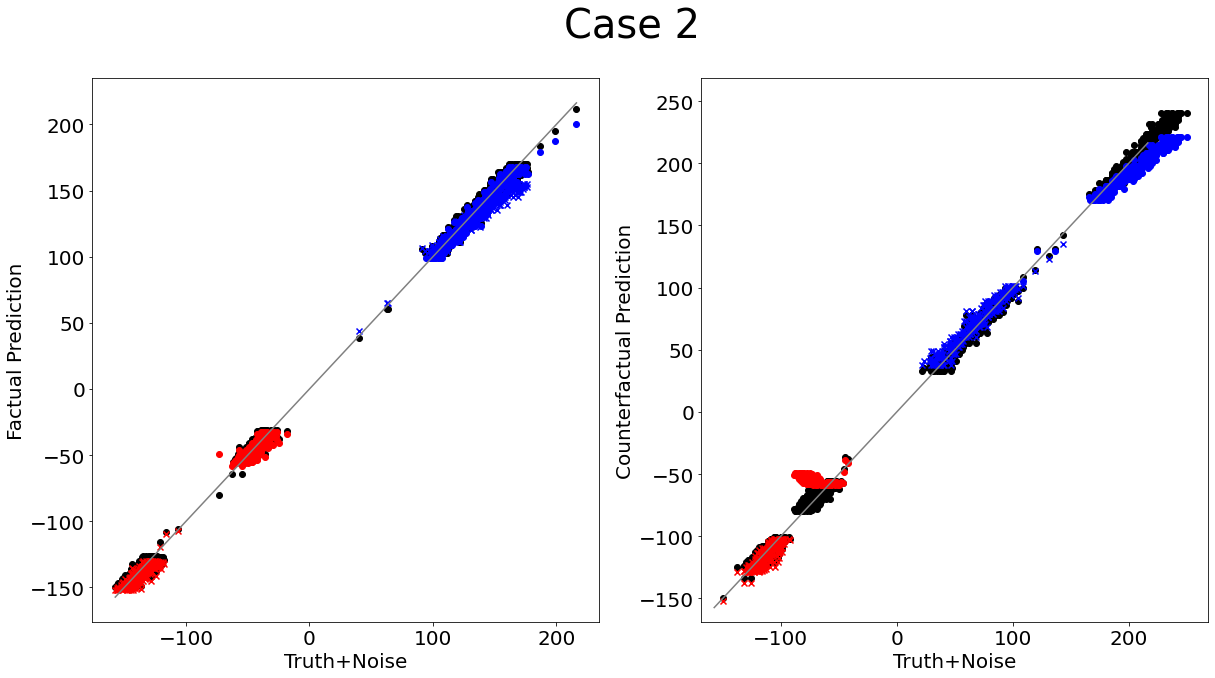

In [19]:
if doDraw:
    yType = str(caseType)
    drawTruthNoise(trainCaseData, yTrainPred, yTrainPredCF, yType, titleAppend=None)

In [20]:
print("{:05f}/{:05f}".format(RMSE(yTrainPred[:, 0], trainCaseData.data['y{}'.format(caseType)]), RMSE(trainCaseData.data['yo{}'.format(caseType)], trainCaseData.data['y{}'.format(caseType)])))
print("{:05f}/{:05f}".format(RMSE(yTrainPredCF[:, 0], trainCaseData.data['y{}CF'.format(caseType)]), RMSE(trainCaseData.data['yo{}CF'.format(caseType)], trainCaseData.data['y{}CF'.format(caseType)])))

6.702091/4.821065
11.305993/5.148489


In [21]:
#del model

In [22]:
saveModel=True
if saveModel:
    PATH="./modelStorage/case{}Model{}.pth".format(caseType, txtSubname)
    t.save(model.state_dict(), PATH)
    the_model = NeuralNetwork()
    the_model.load_state_dict(t.load(PATH))
    print("saved model")

saved model
